# Mini-project: Speech Separation

In this mini-project we will work on the problem of speech separation. We have finished a full pipeline for speech enhancement with both conventional and neural network methods, and a speech separation system can be designed upon that.

The problem of speech separation differs from speech enhancement in the way that speech separation **has more than one targets**. Speech separation aims at separating all active speech signals in a mixture, while speech enhancement only extracts on signal-of-interest and treats all the other sources as noise. Wiener filter becomes harder to apply here as we all know that the human speech signals are nonstationary, so here we will only work on a neural network-based solution, which is also a standard solution nowadays. Again, we will only discuss the single-channel environment here, which is also the most challenging case for separation.

We will introduce a standard method for separation - the **time-frequency masking** method. Time-frequency (T-F) masking operates on frequency domain and has been the most widely-used method in the past decades. Here we will use a neural network to estimate the T-F masks for separation, which is also a popular pipeline in recent years. 

In [1]:
import numpy as np
import librosa
import os
import time
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

## 1. Data Preparation

Similar to the speech enhancement pipeline, we load and listen to the multi-speaker mixtures first.

In [2]:
# load the dataset
tr_dataset = h5py.File('separation-dataset/train', 'r')
val_dataset = h5py.File('separation-dataset/validation', 'r')
test_dataset = h5py.File('separation-dataset/test', 'r')

In [3]:
# listen to one example
from IPython.display import Audio

sample_idx = 15
sample_mixture = test_dataset['mixture'][sample_idx]
sample_speech1 = test_dataset['spk1'][sample_idx]
sample_speech2 = test_dataset['spk2'][sample_idx]

In [4]:
# mixture
Audio(sample_mixture, rate=16000)

In [5]:
# spk1
Audio(sample_speech1, rate=16000)

In [6]:
# spk2
Audio(sample_speech2, rate=16000)

## 2. Time-frequency Masking

Time-frequency (T-F) masking is a core concept in [computational auditory scene analysis (CASA)](https://en.wikipedia.org/wiki/Computational_auditory_scene_analysis). T-F masking oeprates on spectrograms, so we first transform the waveforms of the mixture as well as the clean speech to frequency domain via STFT.

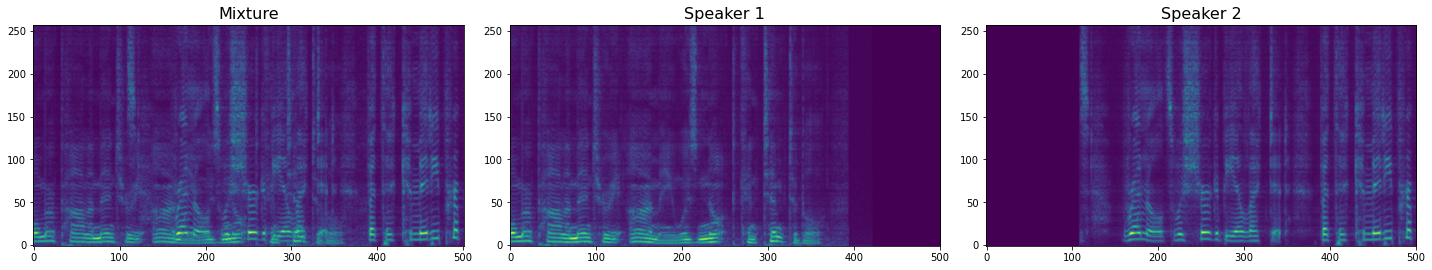

In [7]:
# STFT

mixture_spec = librosa.stft(sample_mixture, n_fft=512, hop_length=128)
spk1_spec = librosa.stft(sample_speech1, n_fft=512, hop_length=128)
spk2_spec = librosa.stft(sample_speech2, n_fft=512, hop_length=128)

# magnitude
mixture_mag_spec = np.abs(mixture_spec)
spk1_mag_spec = np.abs(spk1_spec)
spk2_mag_spec = np.abs(spk2_spec)

# visualization
# I ignore the axis labels here

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
plt.imshow(mixture_mag_spec**.33, origin='lower')
plt.title('Mixture', fontsize=16)
plt.subplot(1,3,2)
plt.imshow(spk1_mag_spec**.33, origin='lower')
plt.title('Speaker 1', fontsize=16)
plt.subplot(1,3,3)
plt.imshow(spk2_mag_spec**.33, origin='lower')
plt.title('Speaker 2', fontsize=16)
plt.tight_layout()

How can we generate or extract the spectrograms of the target speakers from the mixture?

T-F masking treats the separation problem as a **classification** problem. We treat each time-frequency bin in the mixture spectrogram, i.e. each frequency component in each frame, as a feature, and the target speakers as candidate categories. We can then define a **multi-class classification problem**, where each T-F bin needs to be classified to one of the target speakers. All the T-F bins that belongs to one class, i.e. one target speaker, are extracted from the mixture spectrogram, and all the other T-F bins are set to 0. This gives us the separated separated spectrogram of this target speaker.

We know that we have **hard classification** and **soft classification** algorithms. Hard classification algorithms assign **hard labels** to the input features, which are typically binary-valued predictions representing the class assignment. Soft classification algorithms not only predict binary-valued labels, but also gives the assignment probabilities to all the classes. In the problem formulation here, hard classification means that each T-F bin uniquely belongs to only one target source, and soft classification means that each target source owns parts of each T-F bin. That's why we use the term **masking** - we know that the sum of the one-hot labels or the assignment probabilities for each T-F bin is always 1 (the property of a probability distribution), so they all have values between 0 and 1. 

The one-hot label for hard classification is called **ideal binary mask (IBM)**. The calculation of IBM is simple - compare the energy of each T-F bin in the magnitude spectrograms of all target source , and the source with the largest energy owns the entire T-F bin. Let's calculate and visualize it. If one T-F bin belongs to the source, the value of IBM on that T-F bin will be 1, otherwise it will be 0.

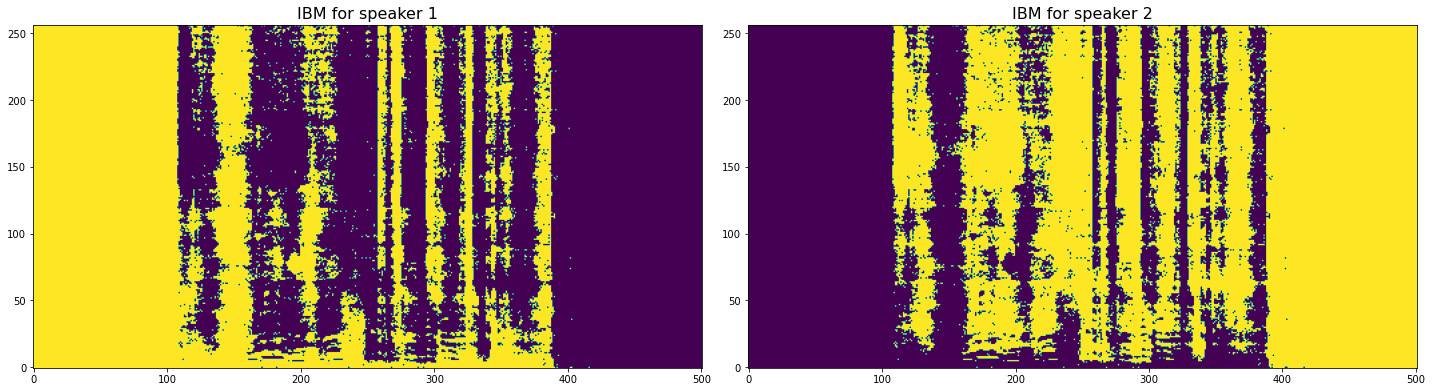

In [8]:
# calculate IBM
# compare the magnitude spectrograms

spk1_IBM = (spk1_mag_spec >= spk2_mag_spec).astype(np.float32)
spk2_IBM = 1 - spk1_IBM

# visualization
# yellow corresponds to 1 and purple corresponds to 0

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(spk1_IBM, origin='lower')
plt.title('IBM for speaker 1', fontsize=16)
plt.subplot(1,2,2)
plt.imshow(spk2_IBM, origin='lower')
plt.title('IBM for speaker 2', fontsize=16)
plt.tight_layout()

We can see that IBMs can reflect the harmonic patterns of each target speaker. To apply IBMs to the mixture spectrogram to extract the separated spectrograms of the targets, simply multiply them to the mixture spectrogram:

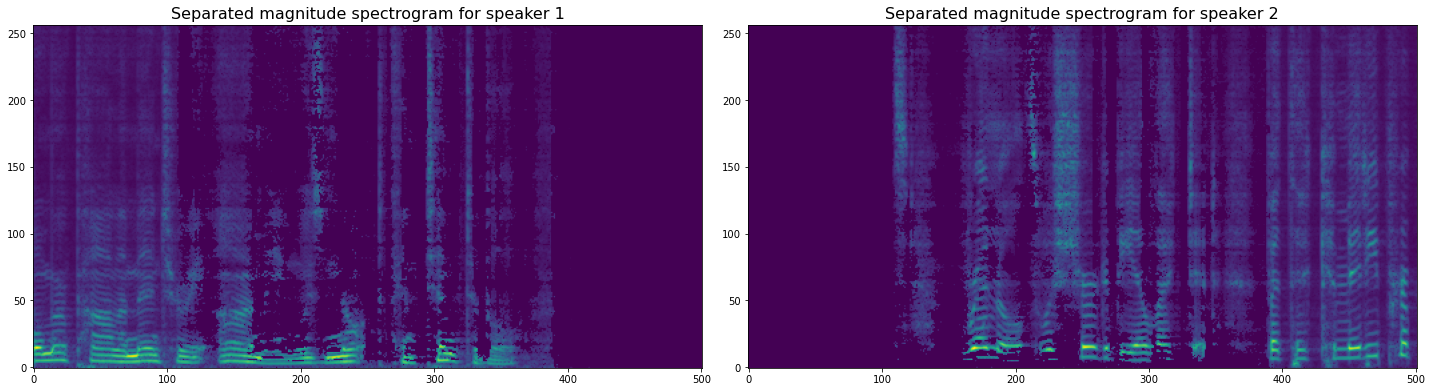

In [9]:
# apply IBM to mixture

separated_spk1_spec = spk1_IBM * mixture_mag_spec
separated_spk2_spec = spk2_IBM * mixture_mag_spec

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(separated_spk1_spec**.33, origin='lower')
plt.title('Separated magnitude spectrogram for speaker 1', fontsize=16)
plt.subplot(1,2,2)
plt.imshow(separated_spk2_spec**.33, origin='lower')
plt.title('Separated magnitude spectrogram for speaker 2', fontsize=16)
plt.tight_layout()

We can observe that there are some distortions comparing with the clean target spectrograms, but we are indeed performing separation here. Waveforms can be reconstructed by these magnitude spectrograms with the phase spectrogram of the mixture spectrogram.

In [10]:
# reconstruct waveforms

separated_spk1_waveform = librosa.istft(separated_spk1_spec * np.exp(1j*np.angle(mixture_spec)),
                                        win_length=512, hop_length=128)
separated_spk2_waveform = librosa.istft(separated_spk2_spec * np.exp(1j*np.angle(mixture_spec)),
                                        win_length=512, hop_length=128)

In [11]:
# separated spk1
Audio(separated_spk1_waveform, rate=16000)

In [12]:
# separated spk2
Audio(separated_spk2_waveform, rate=16000)

T-F masks under soft classification gives us nonbinary values between 0 and 1. There are many ways to calculate such ideal masks, but here we introduce one of them, which is called **Wiener filter mask (WFM)**.

Remember that we implemented the standard Wiener filter in the speech enhancement pipeline. The definition of Wiener filter is:

$M(\omega) = \frac{E[|X(\omega, t)|^2]}{E[|Y(\omega, t)|^2]} = \frac{E[|Y(\omega, t)|^2] - E[|N(\omega, t)|^2]}{E[|Y(\omega, t)|^2]}$

We now treat each T-F bin on its own and define the WFM:

$WFM_i(\omega, t) = \frac{|X_i(\omega, t)|^2|}{|Y(\omega, t)|^2}$

So what's the difference? The expectation operator is removed. Recall that Wiener filter for enhancement does not change over time, and the expectation allows us to calculate the overall statistics across a certain period. Here we are defining WFM for each T-F bin, which is instantaneous.

Notice that we require that the mask values for all target sources sum to 1 for each T-F bin. However, $\sum |X_i(\omega, t)|^2 \neq |Y(\omega, t)|^2$ for magnitude spectrograms of the mixture and the sources. So we modify the denominator to satisfy this constraint:

$WFM_i(\omega, t) = \frac{|X_i(\omega, t)|^2|}{\sum |X_i(\omega, t)|^2}$

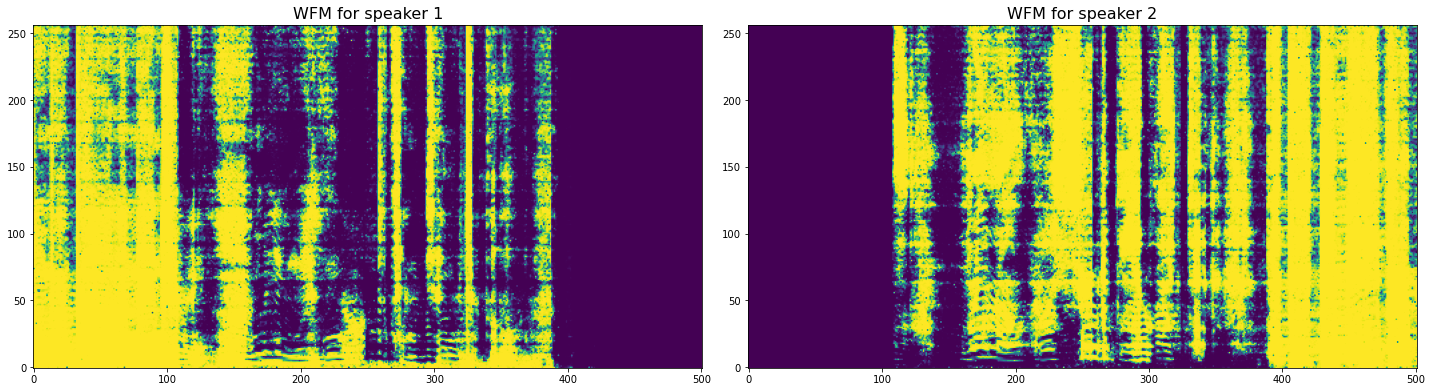

In [13]:
# calculate WFM
# compare the magnitude spectrograms

eps = 1e-6  # numerical stability
spk1_WFM = spk1_mag_spec**2 / (spk1_mag_spec**2 + spk2_mag_spec**2 + eps)
spk2_WFM = spk2_mag_spec**2 / (spk1_mag_spec**2 + spk2_mag_spec**2 + eps)

# visualization

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(spk1_WFM, origin='lower')
plt.title('WFM for speaker 1', fontsize=16)
plt.subplot(1,2,2)
plt.imshow(spk2_WFM, origin='lower')
plt.title('WFM for speaker 2', fontsize=16)
plt.tight_layout()

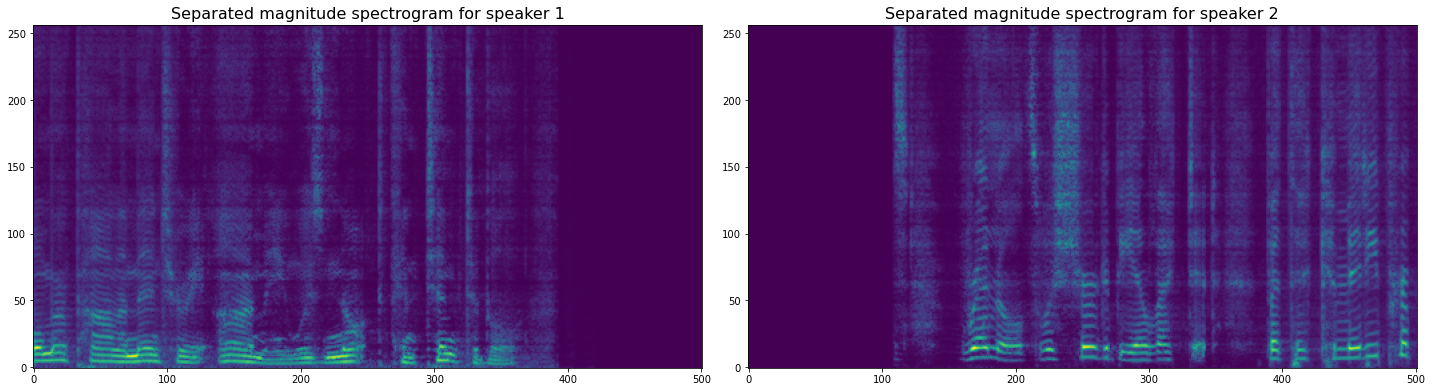

In [14]:
# apply WFM to mixture

separated_spk1_spec = spk1_WFM * mixture_mag_spec
separated_spk2_spec = spk2_WFM * mixture_mag_spec

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(separated_spk1_spec**.33, origin='lower')
plt.title('Separated magnitude spectrogram for speaker 1', fontsize=16)
plt.subplot(1,2,2)
plt.imshow(separated_spk2_spec**.33, origin='lower')
plt.title('Separated magnitude spectrogram for speaker 2', fontsize=16)
plt.tight_layout()

In [15]:
# separated spk1
Audio(separated_spk1_waveform, rate=16000)

In [16]:
# separated spk2
Audio(separated_spk2_waveform, rate=16000)

Compare the outputs from IBM and WFM. What do you find/hear?

In [18]:
# TODO: enter your comments and observations here
'''
listening to the both audios from IBM and WFM there is not much difference in the output and it seems that our brain process the signal as winer takes all. However looking at the spectrogram we can see how the transitions to different spectrotemporal states is smoother in WFM.
'''

'\nlistening to the both audios from IBM and WFM there is not much difference in the output and it seems that our brain process the signal as winer takes all. However looking at the spectrogram we can see how the transitions to different spectrotemporal states is smoother in WFM.\n'

## 3. Permutation Problem in Speech Separation

You may wonder why we work on speech separation after speech enhancement. We can also calculate T-F masks for enhancement task, we can use both SNR and SI-SDR for enhancement, then what's the main difference between enhancement and separation?

The difference is on **the number of outputs**. Enhancement always has one unique output representing the signal-of-interest. Separation has multiple outputs, as it has to separate all active sources in the mixture. When designing supervised learning models or algorithms as what we did in the speech enhancement pipeline, one import problem arises - the so-called **permutation problem**.

Suppose that we have two active speakers in the mixture. In supervised learning framework, we have two clean target signals as the training target. Suppose that we perform training in frequency domain with magnitude spectrograms, then each target signal has shape $(F, T)$ where $F$ and $T$ correspond to the number of frequency components and time steps, respectively. For two targets, we need to concatenate them to form a three-dimensional tensor with shape $(2, F, T)$. For our separation model, we also have two outputs with shape $(F, T)$, resulting in a tensor with the same shape as the target $(2, F, T)$. 

Now here comes the question. For the model outputs, swapping the sequential order of the two outputs should not make any difference - we don't care about the sequential order of the outputs, we only care about what has been separated. However, the sequential order matters in supervised learning as we have a pre-defined sequential order of the targets. Suppose that we have speaker A and B in the mixture, and the sequential order in the training targets is (A, B). Then we need to make sure that A is the first output of the model as well. Further assume that we have three mixtures: one with speaker (A, B), one with speaker (B, C), and one with speaker (A, C). For the first mixture with (A, B), we know that A needs to be the first output and B needs to be the second output. For the second mixture with (B, C), we already know that B should be the second output, so C has to be the first output for this mixture. Then for the third mixture with (A, C), which speaker should be the first output? We don't really have an idea about the sequential order of the outputs in advance, as speaker A and C were both the first outputs in the two previous mixtures. If we assign the wrong sequential order of the target here, the training can fail and can even affect the performance of the other two mixtures.

The abovementioned case is an explanation of the permutation problem - we cannot always assume a fixed sequential order, or **permutation**, of the targets. Researchers have proposed many ways to tackle this problem, and one of the most widely-used method nowadays is called **[permutation invariant training (PIT)](https://ieeexplore.ieee.org/abstract/document/7979557/)**.

The intuition behind PIT is very simple - if we don't really know the correct permutation of the targets during training, why not calculate the objective function on **all permutations** of the targets, and select the one that best fits? Assume that we use MSE as the training objective, then applying PIT on the calculation of MSE becomes:

*pseudo-algorithm for PIT-MSE*:
- input: estimation of shape (C, *), target of shape (C, *), C is the number of target signals
- output: a single scalar
- for permutation $\pi$ in all permutations $\Pi_{C}$:
  * rearrange the permutation of the targets by $\pi$
  * calculate MSE between estimation and target
  * save the MSE value
- Select the smallest MSE value among all permutations as the output

As an example, for $C=2$ we have all possile permutations as $[0, 1]$ and $[1, 0]$, and for $C=3$ we have all permutations as $[0, 1, 2]$, $[0, 2, 1]$, $[1, 0, 2]$, $[1, 2, 0]$, $[2, 0, 1]$, $[2, 1, 0]$. Let's implement this PIT-equipped MSE objective function.

In [54]:
# TODO: implement batch-level MSE objective with PIT in Pytorch
from itertools import permutations

def PIT_MSE(estimation, target):
    """
    args:
        estimation: Pytorch tensor, shape (batch_size, num_target, freq, time)
        target: Pytorch tensor, shape (batch_size, num_target, freq, time)
    output:
        mse: single scalar, average MSE across all dimensions
    """
    
    batch_size, num_target, freq, time = estimation.shape
    prm = list(permutations(range(num_target)))
    MSEs=[]
    for p in prm:
        inp=estimation[:,list(p),:,:]
        inp = inp.view(batch_size, -1)
        output = target.contiguous().view(batch_size, -1)
        loss = (inp - output).pow(2).sum(1)  # (batch_size, 1)
        MSEs.append(loss.mean())
    mse=min(MSEs)
    return mse
b=np.random.rand(5,3,8,5)
d=b
d=b[:,[2,0,1],:,:]
a=torch.tensor(b)
c=torch.tensor(d)
print(PIT_MSE(a,c))

tensor(0., dtype=torch.float64)


In [48]:
b=torch.tensor(np.random.rand(5,8,5))
print(b.size())
b=b.unsqueeze_(1)
print(b.size())

torch.Size([5, 8, 5])
torch.Size([5, 1, 8, 5])


## 4. Neural Network for T-F mask estimation

We now build a network for T-F mask estimation. Similar to the speech enhancement task, we use the same 2-layer LSTM model for this task. The input to the network is the mixture magnitude spectrogram, and the output of the network is two estimated WFMs. The MSE is calculated between the masked mixture spectrograms between the estimated and target WFMs:

$L = ||S(\omega, t) \odot W(\omega, t) - S(\omega, t) \odot \hat{W}(\omega, t)||^2$

where $S(\omega, t)$ is the mixture magnitude spectrogram, $W(\omega, t)$ and $\hat{W}(\omega, t)$ are the target and estimated WFMs, respectively, and $\odot$ means element-wise multiplication. This means that the estimation and the target in the *PIT_MSE* function you implemented above are $S(\omega, t) \odot \hat{W}(\omega, t)$ and $S(\omega, t) \odot W(\omega, t)$, respectively.


Now implement the dataloaders, network, and the training.evaluation pipeline, and train your model. You should be familiar with the process now after we finished homework 1 and the speech enhancement pipeline. Remember that similar to the speech enhancement task, you need to perform MVN inside the network as the dataset is **not** pre-normalized.

In [68]:
# TODO: implement a full pipeline for network training
tr_dataset = h5py.File('separation-dataset/train', 'r')
val_dataset = h5py.File('separation-dataset/validation', 'r')
test_dataset = h5py.File('separation-dataset/test', 'r')
sample_mixture = test_dataset['mixture'][sample_idx]
sample_speech1 = test_dataset['spk1'][sample_idx]
sample_speech2 = test_dataset['spk2'][sample_idx]


from torch.utils.data import Dataset, DataLoader

batch_size = 8

# a class to load the saved h5py dataset
class dataset_pipeline(Dataset):
    def __init__(self, path):
        super(dataset_pipeline, self).__init__()

        self.h5pyLoader = h5py.File(path, 'r')
        
        self.mixture = self.h5pyLoader['mixture']
        self.speech1 = self.h5pyLoader['spk1']
        self.speech2 = self.h5pyLoader['spk2']
        
        self._len = self.mixture.shape[0]  # number of utterances
    
    def __getitem__(self, index):
        # calculate STFT here
        mixture_spec = librosa.stft(self.mixture[index].astype(np.float32), n_fft=512, hop_length=128)
        speech1_spec = librosa.stft(self.speech1[index].astype(np.float32), n_fft=512, hop_length=128)
        speech2_spec = librosa.stft(self.speech2[index].astype(np.float32), n_fft=512, hop_length=128)
        mixture_spec = torch.from_numpy(np.abs( mixture_spec))  # only use the magnitude spectrogram
        speech1_spec = torch.from_numpy(np.abs(speech1_spec))
        speech2_spec = torch.from_numpy(np.abs(speech2_spec))
            
        return mixture_spec, speech1_spec, speech2_spec
    
    def __len__(self):
        return self._len
    
# define data loaders
train_loader = DataLoader(dataset_pipeline('separation-dataset/train'), 
                          batch_size=batch_size, 
                          shuffle=True,
                         )

validation_loader = DataLoader(dataset_pipeline('separation-dataset/validation'), 
                               batch_size=batch_size, 
                               shuffle=False,
                              )
test_loader=DataLoader(dataset_pipeline('separation-dataset/test'), 
                               batch_size=batch_size, 
                               shuffle=False,
                              )

dataset_len = len(train_loader)
log_step = dataset_len // 4
print(dataset_len)

38


In [69]:
# load the training set
tr_name='separation-dataset/train'
h5pyLoader = h5py.File(tr_name, 'r')
mix_speech = h5pyLoader['mixture']
print(np.shape(mix_speech))
for i in range(len(mix_speech)):
    mix_speech_spec = librosa.stft(mix_speech[i].astype(np.float32), n_fft=512, hop_length=128)
    mix_speech_spec = np.abs(mix_speech_spec)  # only use the magnitude spectrogram
    if i==0:
        tr_d=mix_speech_spec[np.newaxis,:,:]
    else:
        tr_d=np.concatenate((tr_d,mix_speech_spec[np.newaxis,:,:]),axis=0)
tr_spec = np.transpose(tr_d[:], (0, 2, 1)).reshape(-1, np.shape(tr_d)[1])  # shape: (num_data*T, n_fft/2+1)
tr_mean = np.mean(tr_spec, axis=0)  # shape: (n_fft/2+1)
tr_var = np.var(tr_spec, axis=0)  # shape: (n_fft/2+1)
tr_std = np.sqrt(tr_var + 1e-8)  # again for numerical stability

(300, 64000)


In [73]:

# a 2-layer LSTM
class extractlastcell(nn.Module):
    
    def forward(self,x):
        out , _ = x
        return out[:, -1, :]
    
class DeepLSTM(nn.Module):
    def __init__(self, feature_dim, meann, stdd):
        super(DeepLSTM, self).__init__()
        
        batch_size=1
        # layers, and activation function
        
        self.feature_dim = feature_dim
        self.hidden_unit = 128  # number of hidden units
        self.InitHidden=1
        self.mean=meann
        self.std=stdd
        # TODO: first LSTM layer
        
        self.layer1 = nn.LSTM(self.feature_dim, self.hidden_unit, num_layers=1, batch_first=True)

        # TODO: second LSTM layer
        self.layer2 = nn.LSTM(self.hidden_unit, self.hidden_unit, num_layers=1, batch_first=True)
        # output layer
        # this is an FC layer 
        self.output = nn.Sequential(nn.Linear(self.hidden_unit, self.feature_dim),
                                    nn.Sigmoid())
        
    # the function for the forward pass of network (i.e. from input to output)
    def forward(self, input):
        # the input is a batch of spectrograms with shape (batch_size, frequency_dim, time_step)
        
        
        batch_size, freq_dim, time_step = input.shape
        #mvn
        input=(input-self.mean.view(1,-1,1)) / self.std.view(1,-1,1)
    
       
        init_hidden1 = torch.zeros(1, batch_size,self.hidden_unit)  # initial hidden state is typically zero matrices
        init_cell1 = torch.zeros(1, batch_size,self.hidden_unit)  # now you also have a initial cell state
        init_hidden2 = torch.zeros(1, batch_size,self.hidden_unit)  # initial hidden state is typically zero matrices
        init_cell2 = torch.zeros(1, batch_size,self.hidden_unit)  # now you also have a initial cell state
        #self.InitHidden=0
        
        # note that LSTM layers require input with shape (batch_size, sequence_length, feature_dim)
        # so here we need to reshape the input
        
        input = input.transpose(1, 2).contiguous()  # (batch, time, freq), swap the two dimensions
        
        input.contiguous().view(batch_size*time_step, -1) #batch*time, freq
        
        # TODO: pass it through the 2 LSTM layers

        output, (output_hidden, output_cell) = self.layer1(input, (init_hidden1, init_cell1))  # process the input
       
        
        output, (output_hidden, output_cell) = self.layer2(output, (init_hidden2, init_cell2))  # process the input
        
        
        # the output should have shape (batch, time, hidden_unit)
        # pass to the output layer
        
        output = self.output(output.contiguous().view(batch_size*time_step, -1))  # (batch*time, freq)
        
        # reshape back
        output = output.view(batch_size, time_step, freq_dim)  # (batch, time, freq)
        output = output.transpose(1, 2).contiguous()  # (batch, freq, time), swap the two dimension back
        #output= output*self.std.view(1,-1,1)+self.mean.view(1,-1,1)
        #mvn
        
        return output, 1-output
    
model_LSTM = DeepLSTM(feature_dim=257, meann=torch.tensor(tr_mean),stdd=torch.tensor(tr_std))
optimizer = optim.Adam(model_LSTM.parameters(), lr=1e-3)

In [74]:
# TODO: training and validation functions

# TODO: functions for training and validation
# Use BCE during training, and Accuracy during validation

def train(model, epoch, versatile=True):
    start_time = time.time()
    model = model.train()  # set the model to training mode. Always do this before you start training!
    train_loss = 0.
    
    # load batch data
    for batch_idx, data in enumerate(train_loader):
        batch_mix = data[0]
        batch_Sp1= data[1]
        batch_Sp2= data[2]
        
        # clean up the gradients in the optimizer
        # this should be called for each batch
        optimizer.zero_grad()
        
        output1, output2 = model(batch_mix)
        output1=output1*batch_mix
        output2=output2*batch_mix
        output1=output1.unsqueeze_(1)
        output2=output2.unsqueeze_(1)
        output=torch.cat((output1, output2), 1)
        
        batch_Sp1=batch_Sp1.unsqueeze_(1)
        batch_Sp2=batch_Sp2.unsqueeze_(1)
        batch_Sp=torch.cat((batch_Sp1, batch_Sp2), 1)
        
        #print('o', output.shape)
        # MSE as objective
        #print('l',batch_label.shape)
        loss = PIT_MSE(output, batch_Sp)
        
        # automatically calculate the backward pass
        loss.sum().backward()
        # perform the actual backpropagation
        optimizer.step()
        
        train_loss += loss.sum().data.item()
        
        # OPTIONAL: you can print the training progress 
        if versatile:
            if (batch_idx+1) % log_step == 0:
                elapsed = time.time() - start_time
                print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | BCE {:5.4f} |'.format(
                    epoch, batch_idx+1, len(train_loader),
                    elapsed * 1000 / (batch_idx+1), 
                    train_loss / (batch_idx+1)
                    ))
    
    train_loss /= (batch_idx+1)
    print('-' * 99)
    print('    | end of training epoch {:3d} | time: {:5.2f}s | BCE {:5.4f} |'.format(
            epoch, (time.time() - start_time), train_loss))
    
    return train_loss
        
def validate(model, epoch):
    start_time = time.time()
    model = model.eval()  # set the model to evaluation mode. Always do this during validation or test phase!
    validation_loss = 0.
    
    # load batch data
    for batch_idx, data in enumerate(validation_loader):
        batch_mix = data[0]
        batch_Sp1= data[1]
        batch_Sp2= data[2]
        
        # you don't need to calculate the backward pass and the gradients during validation
        # so you can call torch.no_grad() to only calculate the forward pass to save time and memory
        with torch.no_grad():
        
            output1, output2 = model(batch_mix)
            output1=output1*batch_mix
            output2=output2*batch_mix
            output1=output1.unsqueeze_(1)
            output2=output2.unsqueeze_(1)
            output=torch.cat((output1, output2), 1)

            batch_Sp1=batch_Sp1.unsqueeze_(1)
            batch_Sp2=batch_Sp2.unsqueeze_(1)
            batch_Sp=torch.cat((batch_Sp1, batch_Sp2), 1)

            #print('o', output.shape)
            # MSE as objective
            #print('l',batch_label.shape)
            loss = PIT_MSE(output, batch_Sp)
        
            validation_loss += loss.data.item()
    
    validation_loss /= (batch_idx+1)
    print('    | end of validation epoch {:3d} | time: {:5.2f}s | accs {:5.4f} |'.format(
            epoch, (time.time() - start_time), validation_loss))
    print('-' * 99)
    
    return validation_loss

In [75]:
# TODO: hyperparameters and model training
# train the model you implemented

total_epoch = 100  # train the model for 100 epochs
model_save = 'best_model_LSTM_WFM.pt'  # path to save the best validation model

# main function

training_loss = []
validation_loss = []

for epoch in range(1, total_epoch + 1):
    training_loss.append(train(model_LSTM, epoch))
    validation_loss.append(validate(model_LSTM, epoch))
    if training_loss[-1] == np.min(training_loss):
        print('      Best training model found.')
    if validation_loss[-1] == np.min(validation_loss):
        # save current best model on validation set
        with open(model_save, 'wb') as f:
            torch.save(model_LSTM.state_dict(), f)
            print('      Best validation model found and saved.')
    
    print('-' * 99)

| epoch   1 |     9/   38 batches | ms/batch 495.30 | BCE 22135.7165 |
| epoch   1 |    18/   38 batches | ms/batch 489.42 | BCE 20493.8894 |
| epoch   1 |    27/   38 batches | ms/batch 487.17 | BCE 20737.9376 |
| epoch   1 |    36/   38 batches | ms/batch 484.02 | BCE 18989.2306 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 18.26s | BCE 18533.6316 |
    | end of validation epoch   1 | time:  2.24s | accs 15188.9430 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
| epoch   2 |     9/   38 batches | ms/batch 490.77 | BCE 15714.8075 |
| epoch   2 |    18/   38 batches | ms/batch 486.33 | BCE 15593.5463 |
| epoch   2 |    27/   38 batches | ms/batch 482.83 | BCE 171

| epoch  12 |     9/   38 batches | ms/batch 478.96 | BCE 17675.5148 |
| epoch  12 |    18/   38 batches | ms/batch 480.56 | BCE 15281.3113 |
| epoch  12 |    27/   38 batches | ms/batch 479.81 | BCE 14985.3177 |
| epoch  12 |    36/   38 batches | ms/batch 482.83 | BCE 14480.4390 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  12 | time: 18.21s | BCE 14724.4830 |
    | end of validation epoch  12 | time:  2.20s | accs 15561.1370 |
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
| epoch  13 |     9/   38 batches | ms/batch 491.41 | BCE 15596.2067 |
| epoch  13 |    18/   38 batches | ms/batch 495.19 | BCE 14219.6634 |
| epoch  13 |    27/   38 batches | ms/batch 496.21 | BCE 13542.2367 |
| epoch  13 |    36/   38 batches | ms/batch 494.39 | BCE 15293.7030

| epoch  23 |    36/   38 batches | ms/batch 480.95 | BCE 11553.2829 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  23 | time: 18.19s | BCE 11361.3695 |
    | end of validation epoch  23 | time:  2.34s | accs 18185.2970 |
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
| epoch  24 |     9/   38 batches | ms/batch 505.08 | BCE 15708.8568 |
| epoch  24 |    18/   38 batches | ms/batch 505.70 | BCE 12694.1050 |
| epoch  24 |    27/   38 batches | ms/batch 496.08 | BCE 12099.7139 |
| epoch  24 |    36/   38 batches | ms/batch 490.32 | BCE 11021.5885 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  24 | time: 18.50s | BCE 10835.9910 |
    | end of validation epoch  24 | time:  2

    | end of validation epoch  34 | time:  2.31s | accs 17443.3021 |
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
| epoch  35 |     9/   38 batches | ms/batch 493.58 | BCE 6204.3981 |
| epoch  35 |    18/   38 batches | ms/batch 493.99 | BCE 7731.7284 |
| epoch  35 |    27/   38 batches | ms/batch 492.35 | BCE 7332.3868 |
| epoch  35 |    36/   38 batches | ms/batch 491.96 | BCE 8091.0471 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  35 | time: 18.57s | BCE 7885.2420 |
    | end of validation epoch  35 | time:  2.30s | accs 17404.5717 |
---------------------------------------------------------------------------------------------------
      Best training model found.
------------------------------------------------------------------------------------

| epoch  46 |     9/   38 batches | ms/batch 490.16 | BCE 3618.5201 |
| epoch  46 |    18/   38 batches | ms/batch 498.92 | BCE 11043.1695 |
| epoch  46 |    27/   38 batches | ms/batch 509.65 | BCE 8688.8357 |
| epoch  46 |    36/   38 batches | ms/batch 507.01 | BCE 7396.0712 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  46 | time: 19.07s | BCE 7130.0980 |
    | end of validation epoch  46 | time:  2.18s | accs 19486.6357 |
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
| epoch  47 |     9/   38 batches | ms/batch 472.56 | BCE 10645.8465 |
| epoch  47 |    18/   38 batches | ms/batch 468.90 | BCE 7176.9873 |
| epoch  47 |    27/   38 batches | ms/batch 468.52 | BCE 5994.9938 |
| epoch  47 |    36/   38 batches | ms/batch 468.98 | BCE 7311.6220 |
----

    | end of validation epoch  57 | time:  2.20s | accs 19767.8713 |
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
| epoch  58 |     9/   38 batches | ms/batch 473.89 | BCE 11179.0974 |
| epoch  58 |    18/   38 batches | ms/batch 472.08 | BCE 9988.3362 |
| epoch  58 |    27/   38 batches | ms/batch 473.06 | BCE 8022.0639 |
| epoch  58 |    36/   38 batches | ms/batch 469.37 | BCE 7087.6927 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  58 | time: 17.69s | BCE 6971.5188 |
    | end of validation epoch  58 | time:  2.15s | accs 19270.3198 |
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
| epoch  59 |   

| epoch  69 |    18/   38 batches | ms/batch 457.26 | BCE 6561.7623 |
| epoch  69 |    27/   38 batches | ms/batch 455.43 | BCE 6402.4703 |
| epoch  69 |    36/   38 batches | ms/batch 454.13 | BCE 5565.6715 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  69 | time: 17.13s | BCE 5376.8400 |
    | end of validation epoch  69 | time:  2.10s | accs 19915.9248 |
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
| epoch  70 |     9/   38 batches | ms/batch 458.40 | BCE 3283.2768 |
| epoch  70 |    18/   38 batches | ms/batch 458.75 | BCE 8351.8306 |
| epoch  70 |    27/   38 batches | ms/batch 462.93 | BCE 6566.0468 |
| epoch  70 |    36/   38 batches | ms/batch 464.03 | BCE 5607.0538 |
----------------------------------------------------------------------------

    | end of validation epoch  80 | time:  2.18s | accs 19656.9438 |
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
| epoch  81 |     9/   38 batches | ms/batch 464.11 | BCE 2631.5434 |
| epoch  81 |    18/   38 batches | ms/batch 464.16 | BCE 2922.6542 |
| epoch  81 |    27/   38 batches | ms/batch 470.14 | BCE 5054.9217 |
| epoch  81 |    36/   38 batches | ms/batch 472.11 | BCE 5574.9857 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  81 | time: 17.82s | BCE 5461.3156 |
    | end of validation epoch  81 | time:  2.15s | accs 19787.1570 |
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
| epoch  82 |    

| epoch  92 |    18/   38 batches | ms/batch 462.77 | BCE 2146.3227 |
| epoch  92 |    27/   38 batches | ms/batch 462.52 | BCE 5039.6648 |
| epoch  92 |    36/   38 batches | ms/batch 461.33 | BCE 4298.9777 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  92 | time: 17.42s | BCE 4187.2442 |
    | end of validation epoch  92 | time:  2.18s | accs 21138.9666 |
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
| epoch  93 |     9/   38 batches | ms/batch 461.95 | BCE 1935.1382 |
| epoch  93 |    18/   38 batches | ms/batch 463.12 | BCE 8878.4937 |
| epoch  93 |    27/   38 batches | ms/batch 462.42 | BCE 6750.5106 |
| epoch  93 |    36/   38 batches | ms/batch 461.89 | BCE 5694.9466 |
----------------------------------------------------------------------------

You may notice that although the MSE on the training set keeps decreasing, the MSE on the validation set remains high after certain number of epochs and may even increase. If you observe this, it means that the model is **overfitting** on the training set so that its **generalization ability** on other datasets is affected. This is mainly because the number of data we use here for training is pretty limited - only 300 utterances. In practice, you need hundreds of hours of mixture to train a good and practical separation system.

Also compare with your observation in the speech enhancement pipeline - we also have 300 training utterances there, but the overfitting phenomenon didn't occur that fast. Why? Can you come up with a possible explanation?

In [79]:
# TODO: enter your thoughts here
''' one reason that the overfitting did not happen there is that our MSE here our mse is tring to find a filter 
(S) and we have no limitations on the weights of the filter S and their distribution so the model has more parameters to adjust
and less data which results to overfitting'''

' one reason that the overfitting did not happen there is that our MSE here our mse is tring to find a filter \n(S) and we have no limitations on the weights of the filter S and their distribution so the model has more parameters to adjust\nand less data which results to overfitting'

Since the model is overfitting, let's see how good it performs on the training set. Here you **do not** need to load the best performing model on validation set.

In [81]:
sample_idx = 10
sample_mixture = tr_dataset['mixture'][sample_idx]
sample_spk1 = tr_dataset['spk1'][sample_idx]
sample_spk2 = tr_dataset['spk2'][sample_idx]



# TODO: evaluate your model on this sample from the training set

mixture_spec = librosa.stft(sample_mixture.astype(np.float32), n_fft=512, hop_length=128)
speech1_spec = librosa.stft(sample_spk1.astype(np.float32), n_fft=512, hop_length=128)
speech2_spec = librosa.stft(sample_spk2.astype(np.float32), n_fft=512, hop_length=128)
mixture_spec = torch.from_numpy(np.abs( mixture_spec))  # only use the magnitude spectrogram
speech1_spec = torch.from_numpy(np.abs(speech1_spec))
speech2_spec = torch.from_numpy(np.abs(speech2_spec))

mixture_spec=mixture_spec.unsqueeze_(0)
speech1_spec=speech1_spec.unsqueeze_(0)
speech2_spec=speech2_spec.unsqueeze_(0)

# do not load the best model found on validation set here!
batch_mix = mixture_spec
batch_Sp1= speech1_spec
batch_Sp2= speech2_spec

output1, output2 = model_LSTM(batch_mix)
output1=output1*batch_mix
output2=output2*batch_mix

output_sample1=np.squeeze(output1.cpu().detach().numpy())

enhanced_signal1 = librosa.istft(output_sample1, win_length=512, hop_length=128)

output_sample2=np.squeeze(output2.cpu().detach().numpy())

enhanced_signal2 = librosa.istft(output_sample2, win_length=512, hop_length=128)






In [83]:
# TODO: listen to your separated output
print('spk1:')
sr=16000
Audio(enhanced_signal1, rate=sr)

spk1:


In [84]:
print('spk2:')
Audio(enhanced_signal2, rate=sr)

spk2:


Now evaluate your model on a sample on the unseen test set. You need to load the best model found on validation set here.

In [86]:
sample_mixture = test_dataset['mixture'][sample_idx]
mix_spec = librosa.stft(sample_mixture.astype(np.float32), n_fft=512, hop_length=128)
mix_spec = torch.from_numpy(np.abs( mix_spec))  # only use the magnitude spectrogram

mix_spec=mix_spec.unsqueeze_(0)


model_LSTM.load_state_dict(torch.load('best_model_LSTM_WFM.pt'))


batch_mix = mix_spec

output1, output2 = model_LSTM(batch_mix)
output1=output1*batch_mix
output2=output2*batch_mix

output_sample1=np.squeeze(output1.cpu().detach().numpy())

enhanced_signal1 = librosa.istft(output_sample1, win_length=512, hop_length=128)

output_sample2=np.squeeze(output2.cpu().detach().numpy())

enhanced_signal2 = librosa.istft(output_sample2, win_length=512, hop_length=128)

# TODO: evaluate your model on this sample from the test set
# remember to load the best model found on validation set

In [87]:
# TODO: listen to your separated output
print('spk1:')
Audio(enhanced_signal1, rate=sr)

spk1:


In [88]:
print('spk2:')
Audio(enhanced_signal2, rate=sr)

spk2:


In [90]:
print('mixture:')
Audio(sample_mixture, rate=sr)


mixture:


Compare the perceptual quality of the separated outputs on the training set and the test set. What's the difference? Which one sounds better?

In [91]:
# TODO: enter your comments here
"The training seems to be better than the test which shows that overfitting is happening"

'The training seems to be better than the test which shows that overfitting is happening'